<a href="https://colab.research.google.com/github/spectrochempy/spectrochempy_tutorials/blob/main/colab/spectrocat_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='green' size='5'> Spectrocat 2022: Process and analyse IR Data</font> 

This tutorial shows how to handle and process spectroscopic data with the python API **SpectroChemPy** (nicknamed scpy) and **Google Colab**. 

SpectroChemPy is not pre-installed in Colab. It is therefore necessary to install it before using it.

To do this, we execute the following shell command:

In [ ]:
! pip install spectrochempy &>> log
exit()

## 1. Import spectrochempy and load data


First, is it required to ``import spectrochempy as scp`` in the current namespace, so that all spectrochempy commands will be called as ``scp.method(<method parameters>)``. We also import other libraries for this tutorial 

In [ ]:
import spectrochempy as scp
import numpy as np

For this tutorial We will load a dataset which was recorded during thecremoval of ammonia from a NH4-Y zeolite:

In [ ]:
D = scp.read_omnic("irdata/nh4y-activation.spg")
D

## 2. Description od the NDDsataset





As you can see above, the spectra and their meta have been imported as a `NDDataset`, a python Class that has been developed to handle data (absorbances) and metadata (title, history, etc...), and stored in `D`.

The main attributes of the NDDataset displayed above are detailed in the following.
- `name` is the name of the group of spectra as it appears in the .spg file. OMNIC sets this name to the .spg filename used at the creation of the group. 
- `author` is that of the creator of the NDDataset The string is composed of the username and of the machine name as given by the OS: `username@machinename`. It can be accessed and changed using `D.author`.
- `created` is the creation date of the NDDataset (again not that of the .spg file). It can be accessed (or even changed) using `D.created`.
- `description` indicates the complete pathname of the .spg file. As the pathname is also given in the history (below), it can be a good practice to give a self explaining description of the group, for instance:

In [ ]:
D.description = "activation of NH4-Y zeolite"
D.description

- `history` records changes made to the dataset. Here, right after its creation, it has been sorted by date (see below).

Then come the attributes related to the data themselves:

- `title` (not to be confused with the `name` of the dataset) describes the nature of data (here **absorbance**).
- The numerical values ar accessed through the`data` attribute and the units throughout `units` attribute.

In [ ]:
D.data

In [ ]:
print(D.units)

- `shape` is the same as the ndarray `shape` attribute and gives the shape of the data array, here 19 x 3112.

Then come the attributes related to the dimensions of the dataset.

- `x`: this dimension has one coordinate (a `Coord` object) made of 5549 the wavenumbers.


In [ ]:
D.x

- `y`: this dimension contains:
    - one coordinate made of the 19 acquisition timestamps
    - two labels
    - the acquisition date (UTC) of each spectrum
    - the name of each spectrum.

In [ ]:
D.y

## 3. Handle Acquisition dates and `y` axis



The acquisition timestamps are the *Unix times* of the acquisition, i.e. the time elapsed in seconds since the
reference date of Jan 1st 1970, 00:00:00 UTC.

In [ ]:
D.y.values

As such these may be not convenient to use directly (they are currently in the order of 1.5 billion...)
With this respect, it can be convenient to shift the origin of time coordinate to that of the 1st spectrum,
which has the index `0`:

In [ ]:
D.y = D.y - D.y[0]
D.y.values

It is also possible to use the ability of SpectroChemPy to handle unit changes. For this one can use the `to` or
`ito` (inplace) methods.
```ipython3
val = val.to(some_units)
val.ito(some_units)   # the same inplace
```

In [ ]:
D.y.ito("minute")
D.y.values

Finally, if for instance you want the `x` time axis to be shifted by 2 minutes, it is also very easy to do so:

In [ ]:
D.y = D.y + 2
D.y.values

## 4. Plotting ans slicing


### 4.1. Basic ploting


Plots of the dataset can be obtained with the `plot()` method.

In [ ]:
_ = D.plot()

### 4.2 slicing

#### Basic Slicing 



In python the slicing of a list or an array means taking elements from a given index
(or set of indexes) to another index (or set of indexes).
Slicing is specified using the colon operator `:` with a `from` and `to` index
before and after the first column, and a `step` after the second column.
Hence, a slice of the object `X` will be set as:

    `X[from:to:step]`

and will extend from the ‘from’ index, ends one item before the ‘to’ index
and with an increment of `step`between each index. When not given the default
values are respectively 0 (i.e. starts at the 1st index),
length in the dimension (stops at the last index), and 1.

Let's first illustrate the concept on a 1D example:

In [ ]:
X = np.arange(10)  # generates a 1D array of 10 elements from 0 to 9
print(X)
print(X[2:5])  # selects all elements from 2 to 4
print(X[::2])  # selects one out of two elements
print(X[:-3])  # a negative index will be counted from the end of the array
print(X[::-2]) # a negative step will slice backward, starting from 'to', ending at 'from'

The same applies to multidimensional arrays by indicating slices separated by commas:

In [ ]:
X = np.random.rand(10, 10)  # generates a 10x10 array filled with random values
print(X.shape)
print(X[2:5, :].shape)  # slices along the 1st dimension, X[2:5,] is equivalent
print(X[2:5, ::2].shape)  # same slice along 1st dimension and takes one 1 column out of two along the second


#### Slicing of NDDatasets



The classical slicing, using integers, can be used. For innstance: But they require For instance, along the 1st dimension:


In [ ]:
print(D[:4])  # selects the first four spectra
print(D[-3:])  # selects the last three spectra
print(D[::2])  # selects one spectrum out of 2

The spectroscopist is generally interested in a particular region of the spectrum, for instance, 4000-2000 cm$^{-1}$. 

A simple mechanism has been implemented in spectrochempy
for this purpose: the use of floats instead of integers will slice the # NDDataset at the corresponding coordinates. For instance to select the 4000-2000 cm$^{-1}$ region:



In [ ]:
_ = D[:, 4000.0:2000.0:].plot()

The same mechanism can be used along the first dimension (`y`).
For instance, to select and plot the same region and the spectra recorded between 80 and 180 minutes:

In [ ]:
_ = D[80.0:180.0, 4000.:3000.].plot()   # Note that a decimal point is enough to get a float

## 5. Baseline corrections



### 5.1 Background subtraction



Often, particularly for surface species, the baseline is first corrected by subtracting a reference spectrum. In this example, it could be, for instance, the last spectrum (index -1). Hence:

In [ ]:
Ddiff = D - D[-1]
_ = Ddiff.plot()

### 5.2. Detrend



Other simple baseline corrections - often use in preprocessing prior chemometric analysis - constist in shifting the spectra or removing a linear trend. This is done using the `detrend()` method, which is a wrapper of the [detrend() method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html) from the [# scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) module. 

Two types of trend can be used: `'linear'` (default) will subtract the linear trend of each spectrum, `'constant'` will subtract a constant value for each spectrum.

In [ ]:
_ = D.detrend().plot()

In [ ]:
_ = D.detrend(type="constant").plot()

### 5.3. Advanced baseline correction




'Advanced' baseline correction basically consists for the user to choose:

- spectral ranges which s/he considers as belonging to the baseline 
- the type of polynomial(s) used to model the baseline in and between these regions (keyword: `interpolation`) 
- the method used to apply the correction to spectra: sequentially to each spectrum, or using a multivariate approach (keyword: `method`).

### Range selection

Each spectral range is defined by a list of two values indicating the limits of the spectral ranges, e.g. `[4500., 3500.]` to
select the 4500-3500 cm$^{-1}$ range. Note that the ordering has no importance and
using `[3500.0, 4500.]` would lead to exactly the same result. It is also possible to formally pick a single
wavenumber `3750.`.

The first step is then to select the various regions that we expect to belong to the baseline

In [ ]:
ranges = [5900.0, 5400.0], 4550.0, [4500.0, 4000.0], [2100.0, 2000.0], [1550.0, 1555.0]

After selection of the baseline ranges, the baseline correction can be made using a
sequence of 2 commands:

- Initialize an instance of BaselineCorrection
- Compute baseline other the ranges

In [ ]:
blc = scp.BaselineCorrection(D)
Dcorr = blc.compute(ranges)
_ = Dcorr.plot()

### Playing with the options

Now your turn: the following code will baselinecorrect and display the results. 
Change all 'user defined parameters' required to baseline correct the last spectra in the OH region...

In [ ]:
# user defined parameters
# -----------------------

D_ = D[:,:] # time and wavenumber ranges   

ranges = (
    [5900.0, 5400.0],
    [4000.0, 4500.0],
    4550.0,
    [2100.0, 2000.0],
    [1550.0, 1555.0],
    [1250.0, 1300.0],
    [800.0, 850.0],
)
interpolation = "polynomial"  # choose 'polynomial' or 'pchip'
order = 1  # only used for 'polynomial'
method = "sequential"  # choose 'sequential' or 'multivariate'
npc = 3  # only used for 'multivariate'

# code: compute baseline, plot original and corrected NDDatasets and ranges
# -------------------------------------------------------------------------

blc = scp.BaselineCorrection(D_)
D_corr = blc.compute(
    *ranges, interpolation=interpolation, order=order, method=method, npc=npc
)

axes = scp.multiplot(
    [D_, D_corr],
    labels=["Original", "Baseline corrected"],
    sharex=True,
    nrow=2,
    ncol=1,
    figsize=(7, 6),
    dpi=96,
)
blc.show_regions(axes["axe21"])


## 6. Smoothing and derivatives

Here, we will learn to smooth spectra along one dimension. L'et's first select a loisy part if the spectra 

In [ ]:
D_n = D[0:5, 3600.0:2800.0] 
_ = D_n.plot()

### 6.1 Smoothing

#### The `smooth()` method

The `smooth()` method is adapted from the ["Smoothing of a 1D signal" code](
https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html) of the [Scipy cookbook](
https://scipy-cookbook.readthedocs.io/). It is a (weighted)-moving average method and consist in the convolution of
a window of a given length with the spectrum.

In its simplest form - *i.e.* unweighted moving average - each absorbance at a given wavenumber of the smoothed
spectrum is the average of the absorbance at the absorbance at the considered wavenumber and the N neighboring
wavenumbers (*i.e.* N/2 before and N/2 after), hence the conventional use of an odd number of N+1 points to define
the window length. For the points located at both end of the spectra, the extremities of the spectrum are mirrored
beyond the initial limits to minimize boundary effects.

When passed as is, i.e. `X.smooth()`, the method uses a moving average of 5 points:

In [ ]:
_ = D_n.smooth().plot()

The following code compares the influence of the window size on the smoothing of the first spectrum of the NDDataset `X[0]`.


In [ ]:
spectra_list = [D_n[0],]
labels = ["Initial", ]

for i, length in enumerate([5, 11, 27, 51, 101, 201, 501]):
    s = D_n[0].smooth(window_length=length)  # smooth
    s += 0.1 * (1 + i)  # shift the absorbance by +0.1 a.u. with respect to previous iteration
    spectra_list.append(s)
    labels.append(f"length: {length}")

D_s = scp.stack(spectra_list)
_ = D_s.plot()

For large windows, the spectrum is flattened out and distorted. When determining the optimum window length, one should thus consider the balance between noise removal and signal integrity: the larger the window length, the stronger the smoothing, but also the greater the chance to distort the spectrum.

#### Savitzky-Golay algorithm:savgol_filter()

The second algorithm implemented in spectrochempy is the Savitzky-Golay filter which uses a polynomial interpolation in the moving window. A demonstrative illustration of the method can be found on the [Savitzky-Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) entry of Wikipedia.

The function implemented in spectrochempy is a wrapper of the [savgol_filert() method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) from the [scipy.signal](
https://docs.scipy.org/doc/scipy/reference/signal.html) module. 

It not only used to smooth spectra but also to compute their successive derivatives. The latter are treated below. We focus here on the smoothing which is the default of the filter (default parameter: `deriv=0`).

As for the `smooth()` method, it is a moving-window based method. Hence, the window length (`window_length` parameter) plays an equivalent role, except that it *must* be odd. Moreover, instead of choosing a window function,
the user can choose the order of the polynomial used to fit the window data points (`polyorder`, default value: 0).
The latter must be strictly smaller than the window size (so that the polynomial coefficients can be fully determined).

The use of this method is illustrated below.  You can assess the impact of the window length and polynomial order: 

In [ ]:
_ = D_n.savgol_filter(window_length=11, polyorder=6).plot()

#### Exercise



What would be the parameters to use in the `savogol_filter()` method to mimic `smooth()`?

Write a code to check your answer 

### 6.2. Derivatives



Derivatives - particularly second derivatives - are useful tu determine peak positions, specially when shouldes are present.

In [ ]:
D_l = D[1:5, 1900.:1300.] 
D_der = D_l.savgol_filter(window_length=25, deriv=2, polyorder=2)

_ = D_l.plot()
_ = D_der.plot()

## 7. Peak integration



Here we learn how to find peak maxima and determine peak areas with spectrochempy. 

In [ ]:
D_m = (D - D[-1])[:, 1750.0:1550.0]
_ = D_m.plot()

We need first to define and correct the baseline (see above for details)

In [ ]:
blc = scp.BaselineCorrection(D_m)
ranges = (
    [1750.0, 1700.0],
    [1600.0, 1550.0])  # define  regions where we want the baseline to reach zero.
D_mc = blc.compute(*ranges, order=2)  # compute the corrected NDDataset
_ = D_mc.plot() 


To integrate each spectrum on the full range, we can use the `simps` (simpson integration)  or `trapz` (trapezoid integration) method of a NDDataset. Both give in general very close results.

In [ ]:
areas = D_mc.trapz()
_ = areas.plot()

## 8. Principal component analysis

Here we will learn how to use PCA to estimate the minimum number of species to consider for a correct modelling of the spectra. We will work on the 1900-1300 region whare we can expect bands from water and ammonia). 

In [ ]:
D_n = (D - D[-1])[:, 1750.:1300.]
D_n.plot()

In [ ]:
blc = scp.BaselineCorrection(D_n)
ranges = 1750.0, 1560., 1300.  # define  regions where we want the baseline to reach zero.
D_nc = blc.compute(ranges, order=3)  # compute the corrected NDDataset
_ = D_nc.plot() 


PCA is widely ised in data science to reduce datasets to a lower dimensionality by factorising the dataset into score ($S$) loading ($L^T$) matrices of of a limited number of components and minimize the error E. 

$$ D = S \, L^T + E$$

The choice of the correct nuumber of components is a delicate matter:; it can be based on:
- examination of the explaine variance
- examination of the scores and loadings
- comparison of the experilmental vs. reconstructed dataset

L'et's first make a PCA and exaline the "figures of merit":

In [ ]:
pca = scp.PCA(D_nc)
pca.printev(n_pc=5)


In spectroscopy, the first component always explains a huge part of the variance (here 98.257%). But this does not mean that the reconstruction will be satisfactory with a single PC !

Let’s look at the score and loading matrices:

In [ ]:
S, LT = pca.reduce(n_pc=5)
_ = S.T.plot()
_ = LT.plot()

The loadings are the weights of each wavenumber in a given PC (so they have the same dimension as a spectrum) and the scores represent the coordinates of each spectrun on the corresponding principal component (PC) (so they their length is the lumber of spectra). But despite their dimensions, scores and loadings are not "abstract concentration profiles" or "abstract spectra" ! 

Still, the contribution of each PC to the spectra can be obtained by the matrix multiplication of its score and loading. For instance for the first component:

In [ ]:
PC_1 = scp.dot(S[:,0], LT [0,])
_ = PC_1.plot()

As seen above the loadings have similar amplitudes, so the contribution of each PC to the spectra can be estimates by looking at the amplitude of the Scores. Visual inpection of the scores suggest that no more than 3 components are required. 
Deciding whether 2 or 3 components are required is a matter of choice and knowledge of the system. Comparing reconstructed and experimental datasets can also help in the decision.

In [ ]:
_ = pca.plotmerit(n_pc=2)
_ = pca.plotmerit(n_pc=3)

## MCR-ALS


MCR-ALS (standing for Multivariate Curve Resolution - Alternating Least Squares) is a popular method for resolving a set (or several sets) of spectra $X$ of an evolving mixture (or a set of mixtures) into the spectra $S^T$ of 'pure'species and their concentration profiles $C$. In terms of matrix equation:

$$ X = C S^T + E $$

While the equations are similar to PCA, here we try to obtain chemically/spectroscopically relevant concentrations and spectrizcopic profiles.

The optimization of the MCR equation above requires the input of a guess for either the concentration matrix $C_0$ or the spectra matrix $S^T_0$. Given the data matrix $X$, the lacking initial matrix ($S^T_0$ or $C_0$,
respectively) is computed by:
$$ S^T_0 = \left( C_0^TC_0 \right)^{-1} C_0^T X $$
or
$$ C_0 = X {S^T_0}^T  \left( S_0^T {S_0^T}^T \right)^{-1} $$

The ALS algorithm allows applying soft or hard constraints (e.g., non negativity, unimodality, equality to a given profile to the spectra or concentration profiles of pure species. This property makes MCR-ALS an extremely flexible and powerful method. 

If we consider two components, we can expect that absorbances at 1644 and 1430 cm-1 could provide a rough estilmate of theu concentration profiles:

If we consider two components, we can expect that absorbances at 1644 and 1430 cm-1 could provide a rough estilmate of theu concentration profiles:

In [ ]:
# ## guess pure spectra 

c1 = D_nc[:,1644.] / D_nc[:,1644.].max() 
c2 = D_nc[:,1430.] / D_nc[:,1430.].max()

C0 = scp.concatenate(c1, c2, dims='x')
C0.T.plot(title="Guess concentration profiole")

In [ ]:
scp.set_loglevel("INFO")
mcr = scp.MCRALS(D_nc, C0)

The optimization has converged within few iterations. The figures reported for each iteration are defined as follows:

- 'Error/PCA' is the standard deviation of the residuals with respect to data reconstructed by a PCA with as many
components as pure species (2 in this example),
- 'Error/exp': is the standard deviation of the residuals with respect to the experimental data X,
- '%change': is the percent change of 'Error/exp' between 2 iterations

The default is to stop when this %change between two iteration is negative (so that the solution is improving),
but with an absolute value lower than 0.1% (so that the improvement is considered negligible). 

Now we can examine the C and St matrices:

In [ ]:
_ = mcr.C.T.plot()
_ = mcr.St.plot()

And look at the quality (or not...) of the reconstruction:

In [ ]:
_ = mcr.plotmerit()

The residuals (is red in the figure above) can be computed and examined more closely:

In [ ]:
residuals = D_nc - mcr.reconstruct()
_ = residuals.plot()

A large part of these residuals probably result from band shift or broadening.
Whether such features shoud be considered as indicative of new species and require a 3- or 4- species model goes beyond the obkjectives of this introductory tutorial...

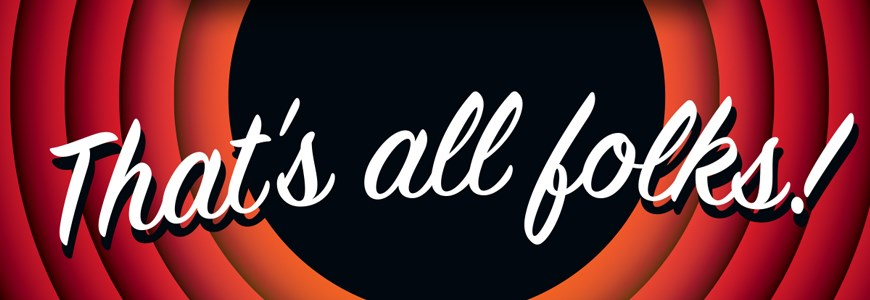